In [1]:
#Objective:
# val acc ~72% normally on a small dataset
#To counter over-fitting, use dropout (?), weight decay (L2 regularization) and data augmentation
# val acc due to drop out and augmentation increased to ~82
# next to further improve: use a pre-trained convnet model!
# A pre-trained model, trained on a larger set. A generic model develops features that can
#be used even on a small data problem
#2 ways to use it: 1) feature extraction 2 options 2) fine-tuning
#we are using VGG16 pre-trained model architechture (ResNet, Inception, Xception etc are others)


In [2]:
#System Check
import sys;print('python version:',sys.version) 
import tensorflow as tf;print('tf_version:',tf.__version__) #tf: 2.1 
from tensorflow import keras; print('keras version:',keras.__version__) 
import keras 
print("keras version on its own:",keras.__version__) #tf keras and keras library can have different versions
from tensorflow.python.platform import build_info as tf_build_info 
#print('CUDA Version:',tf_build_info.cuda_version_number) 
#print('CUDNN Version:',tf_build_info.cudnn_version_number)

import tensorflow as tf
tf.test.is_gpu_available() # True/False
print("GPU Status:",tf.test.is_gpu_available())

#Releases the python gpu memory
from numba import cuda
cuda.select_device(0)
cuda.close()

"""
# Or only check for gpu's with cuda support
tf.test.is_gpu_available(cuda_only=True) 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
"""

python version: 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0]
tf_version: 1.14.0
keras version: 2.2.4-tf
keras version on its own: 2.2.4
GPU Status: False


Using TensorFlow backend.


"\n# Or only check for gpu's with cuda support\ntf.test.is_gpu_available(cuda_only=True) \nfrom tensorflow.python.client import device_lib\nprint(device_lib.list_local_devices())\n"

In [3]:
# Feature Extaction#######
#representations learned by a previous network to extract interesting features 
#from new samples. This is then run through a new classifier
#Old conv base + New Classifier
# Key concept: Since representations of the 1st few layers are local, non-generic features
# so we don't use the first few layers or the top and use higher generic layers only

from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, #this is the classifer that we dont use; also image net classifier has 1000 categories whereas we only have 1
                  input_shape=(150, 150, 3)) #optional; it can process any size

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
conv_base.summary()
#the final feature map has shape 4,4,512 on top of which we will connect desely-connected classifier

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [5]:
#The final feature map has shape (4, 4, 512). That's the feature on top of which we will stick a densely-connected classifier.
#2 options:

# Option 1)
# Run conv base over each image once >store output on numpy >connect it to classifier
#Good: runs expensive conv base 1
#Bad: does not allow data augmentation

#Option 2
#Conv base + classifier (dense layer) on each image. Allows data aug
#computationally expensive

#####option 1########################################################
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/oj/Downloads/project/images'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

###????### So we dont have train/val/test generator but rather we extract train/val/test features and labels

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels
###????####Does it generate labels? We have not provided it?
train_features, train_labels = extract_features(train_dir, 160) 
validation_features, validation_labels = extract_features(validation_dir, 20)
test_features, test_labels = extract_features(test_dir, 20)

Found 160 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


In [6]:
#So it does learn features and shapes
"""
print (train_labels)
print (len(train_labels))
print (test_labels)
print (len(test_labels))
print('features shape:', test_features)
"""

"\nprint (train_labels)\nprint (len(train_labels))\nprint (test_labels)\nprint (len(test_labels))\nprint('features shape:', test_features)\n"

In [7]:
#The extracted features are currently of shape (samples, 4, 4, 512). We will feed them to a densely-connected classifier, 
#so first we must flatten them to (samples, 8192):
#4*4*512

train_features = np.reshape(train_features, (160, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (20, 4 * 4 * 512))
test_features = np.reshape(test_features, (20, 4 * 4 * 512))



In [8]:
#At this point, we can define our densely-connected classifier (note the use of dropout for regularization), 
#and train it on the data and labels that we just recorded:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))


In [ ]:
model.save('opus_feature_extraction_wout_data_aug.h5')
mode

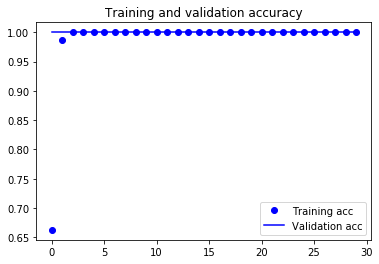

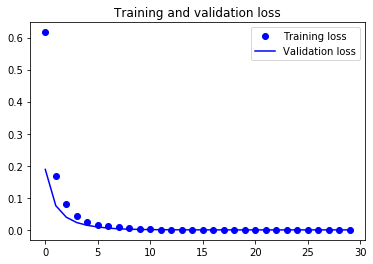

In [8]:
#Training is very fast, since we only have to deal with two Dense layers -- an epoch takes less than one second even on CPU.
#Let's take a look at the loss and accuracy curves during training

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Accuracy is over 90% but we are over-fitting
#data aug is not used

In [ ]:
#########################OPTION 2 Feature Extraction With Data Augmentation

In [34]:
#Option2 - W Data Aug -only attempt if there is a gpu
#Because models behave just like layers, you can add a model (like our conv_base) to a Sequential model just like you would add a layer. 
#So you can do the following:


from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, #this is the classifer that we dont use; also image net classifier has 1000 categories whereas we only have 1
                  input_shape=(150, 150, 3)) #optional; it can process any size

conv_base.summary()
#the final feature map has shape 4,4,512 on top of which we will connect desely-connected classifier

from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base) 
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [35]:
#As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 million parameters.
#Before we compile and train our model, 
#a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of layers means preventing their weights from getting updated during training. If

print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False #in keras, that is how you freeze it


print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [36]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


Found 160 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


In [37]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8, #160 images; batches of 20; therefore, SPE = 8 (8*20=160)
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
 - 44s - loss: 0.2114 - acc: 0.9875 - val_loss: 0.0736 - val_acc: 1.0000
Epoch 2/30
 - 48s - loss: 0.0508 - acc: 1.0000 - val_loss: 0.0331 - val_acc: 1.0000
Epoch 3/30
 - 48s - loss: 0.0243 - acc: 1.0000 - val_loss: 0.0183 - val_acc: 1.0000
Epoch 4/30
 - 49s - loss: 0.0139 - acc: 1.0000 - val_loss: 0.0109 - val_acc: 1.0000
Epoch 5/30
 - 48s - loss: 0.0084 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 1.0000
Epoch 6/30
 - 49s - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 7/30
 - 49s - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 8/30
 - 49s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 9/30
 - 51s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 10/30
 - 50s - loss: 8.7900e-04 - acc: 1.0000 - val_loss: 7.3715e-04 - val_acc: 1.0000
Epoch 11/30
 - 50s - loss: 5.6564e-04 - acc: 1.0000 - val_loss: 4.9406e-04 - val_acc: 1.0000
Epoch 12/30
 - 50s - loss: 3.8779e-04 - acc: 1.0000 - val_

In [38]:
model.save('opus_convnet_feature_wdata_aug.h5')

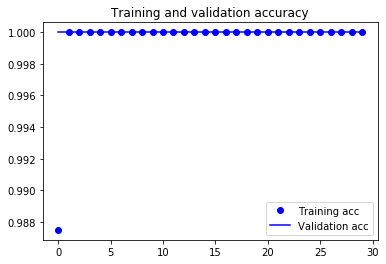

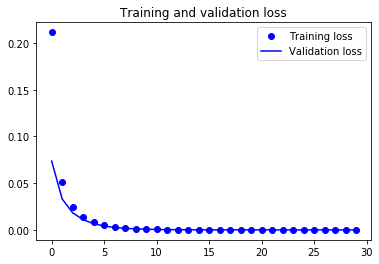

In [39]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

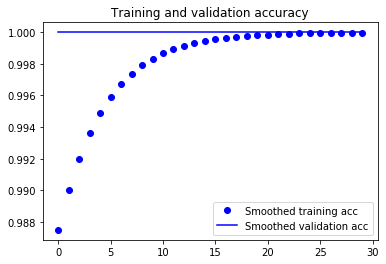

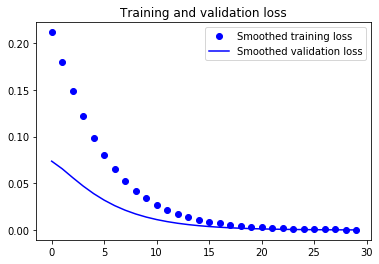

In [40]:
#making above graphs smoother. This is done by replacing every loss and accuracy with exponential moving averages
#This is for readability

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Found 20 images belonging to 1 classes.
test acc: 1.0
Found 160 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


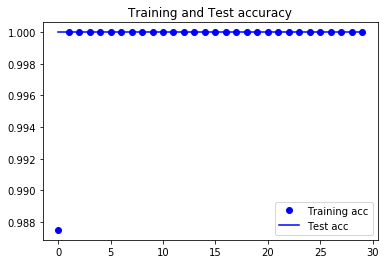

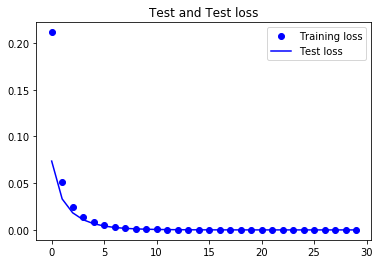

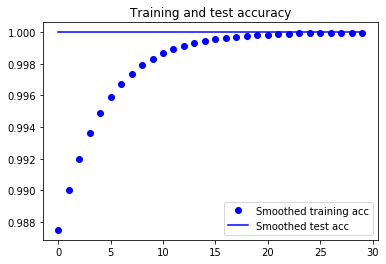

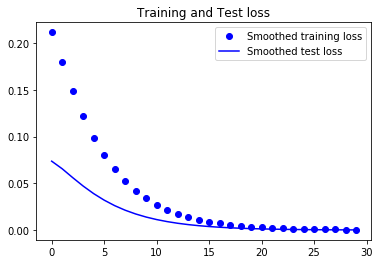

In [42]:
#finally on test data
import matplotlib.pyplot as plt

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

#####################################
####My own test acc printing#####

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

test2_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')



acc = history.history['acc']
test2_acc = history.history['val_acc'] #test_acc is in model.evaluate but you can plot it using the val_Acc and pointing it to the test_dir
loss = history.history['loss']
test2_loss = history.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Test acc')
plt.title('Training and Test accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Test loss')
plt.title('Test and Test loss')
plt.legend()

plt.show()


def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(test2_acc), 'b', label='Smoothed test acc')
plt.title('Training and test accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(test2_loss), 'b', label='Smoothed test loss')
plt.title('Training and Test loss')
plt.legend()

plt.show()

In [ ]:
"""
Take-aways: using convnets with small datasets
Here's what you should take away from the exercises of these past two sections:

Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very small dataset, with decent results.
On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image data.
It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with small image datasets.
As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.
Now you have a solid set of tools for dealing with image classification problems, in particular with small datasets.